In [18]:
### What to try next
# Implement using max Pooling layers instead of conv2d Layers, 
# inspect the encoded information to see what can be done with the DATA
#Ze Hao task ^^^

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

# # This will make the input from -1 to 1, apply nn.Tanh as last layer if this happens
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])

mnist_data = datasets.MNIST(root = './data', train = True, download = True, transform = transform)

data_loader = torch.utils.data.DataLoader(dataset = mnist_data, batch_size = 64, shuffle = True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Processing...


E:\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [3]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        #Image size:N, 28 * 28
        #reduce this witha few linear layers
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), #reduce N, 784 > N, 128
            nn.ReLU(), 
            nn.Linear(128, 64), #(inpur, output)
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), # Final output > N,3 , 3 output laters
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(), 
            nn.Linear(12, 64), #(inpur, output)
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), 
            #Because the input in 0 and 1, the output should also be between 0 and 1
            #if the input image is in the range of [-1, 1], we use nn.Tanh. Might happen when we apply a normalization
            nn.Sigmoid()
        )
        
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        


In [5]:
# CNN Usually perform much better

class Autoencoder_CNN(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        #Image size:N, 28, 28
        #reduce this with a few Convolution Layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )
        
# Normally, we can use 
# nn.MaxPool2d -> nn.MaxUnpool2d
# MaxPool will reduce the size, unPool reverse, so we can use in the decoder
        

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [6]:
# Create the new model for the CNN Autoencoder

In [7]:
# model = Autoencoder()
model = Autoencoder_CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

In [8]:
# Training for CNN Autoencoder

num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #Reconstructed img, Likely going to be 
        recon  = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon, )) 

Epoch:1, Loss:0.0086
Epoch:2, Loss:0.0060
Epoch:3, Loss:0.0046


KeyboardInterrupt: 

(32, 1, 28, 28)


IndexError: list index out of range

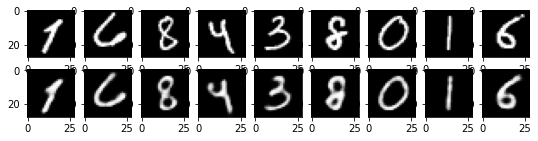

<Figure size 648x144 with 0 Axes>

In [9]:
#Plotting the images for convolutional Autoencoder

for k in range(0, num_epochs, 5):
    plt.figure(figsize = (9,2))
    plt.gray()
    
    #because it is a Tensor, so we want to detach and then convert into a numpy array
    imgs = outputs[k][1].detach().numpy()
    print(imgs.shape)
    recon = outputs[k][2].detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9:
            break
        plt.subplot(2, 9, i + 1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9 :
            break
        plt.subplot(2, 9, 9 + i + 1)
        plt.imshow(item[0])

In [16]:
print(list(model.children())[0][2])

Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
torch.Size([64, 1, 7, 7])
torch.Size([64, 1, 7, 7])
torch.Size([3, 74, 74])


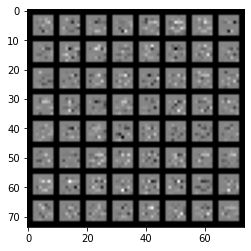

In [22]:
# Filter Plotting Testing
children = list(model.children())[1]
count = 0
# while(not isinstance(children[count], nn.ConvTranspose2d)):
#     count +=1
    
# printing the layer type
print(children[count])
kernels = children[count].weight.detach().clone().cpu()[:, 0:1, :, :]
print(kernels.shape)
# normalize to (0,1) range so that matplotlib
# can plot them
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
print(kernels.shape)
filter_img = torchvision.utils.make_grid(kernels, nrow = 8)
# change ordering since matplotlib requires images to 
# be (H, W, C)
print(filter_img.shape)
plt.imshow(filter_img.permute(1, 2, 0))

In [ ]:
#Training for Autoencoder

num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #so we reshape to make it flat
        img = img.reshape(-1, 28*28)
        
        #Reconstructed imag, Likely going to be 
        recon  = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

In [ ]:
#Plotting the images

for k in range(0, num_epochs, 4):
    plt.figure(figsize = (9,2))
    plt.gray()
    
    #because it is a Tensor, so we want to detach and then convert into a numpy array
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9:
            break
        plt.subplot(2, 9, i + 1)
        item = item.reshape(-1, 28, 28)
        
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9 :
            break
        plt.subplot(2, 9, 9 + i + 1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])